In [1]:
import SimpleITK as sitk
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from ipywidgets import interact
from ipywidgets.widgets import IntSlider
import cv2
import ants as ants
import matplotlib.pyplot as plt
import pydicom
from matplotlib.colors import ListedColormap
import os
import ImageTool.tool as tool
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import pandas as pd

In [2]:
target = "3/Pig1/"
save_path = os.path.join("/media/molloi-lab-linux2/Seagate Backup Plus Drive/ZQY/Alireza", target)
path_rest = os.path.join(save_path, "Acq_02_Baseline/DICOM/02")
path_stress = os.path.join(save_path, "Acq_04_Stress/DICOM/02")
lmmask_path_rest = os.path.join(save_path, "Acq_02_Baseline/SEGMENT_dcm/LEFT_MYOCARDIUM_dcm")
lmmask_path_stress = os.path.join(save_path, "Acq_04_Stress/SEGMENT_dcm/LEFT_MYOCARDIUM_dcm")
aorta_rest_mask = os.path.join(save_path, "Acq_02_Baseline/SEGMENT_dcm/AORTA_dcm")
aorta_stress_mask = os.path.join(save_path, "Acq_04_Stress/SEGMENT_dcm/AORTA_dcm")
bolus_rest = os.path.join(save_path, "Acq_02_Baseline/SureStart")
bolus_stress = os.path.join(save_path, "Acq_04_Stress/SureStart")

In [3]:
def fun(img):
    x = img.copy()
    x[x > -400] = 1
    x[x < 0] = 0
    return x

In [4]:

mask_rest_left = tool.load_2d_3d(lmmask_path_rest) 
mask_rest_right = tool.load_2d_3d(lmmask_path_rest.replace("LEFT", "RIGHT")) 
full_rest_mask = fun(sitk.GetArrayFromImage(mask_rest_left)) | fun(sitk.GetArrayFromImage(mask_rest_right))
full_rest_image = sitk.GetImageFromArray(full_rest_mask)
full_rest_image.CopyInformation(mask_rest_left)

mask_stress_left = tool.load_2d_3d(lmmask_path_stress) 
mask_stress_right = tool.load_2d_3d(lmmask_path_stress.replace("LEFT", "RIGHT")) 
full_stress_mask = fun(sitk.GetArrayFromImage(mask_stress_left)) | fun(sitk.GetArrayFromImage(mask_stress_right))
full_stress_image = sitk.GetImageFromArray(full_stress_mask)
full_stress_image.CopyInformation(mask_stress_left)

In [5]:
save_files = os.path.join(save_path, "python")
tool.make_if_dont_exist(save_files)
tool.load_2d_3d(path_rest, save_files + "/rest.nii")
tool.load_2d_3d(path_stress, save_files + "/stress.nii")
sitk.WriteImage(full_rest_image, save_files + "/full_rest_mask.nii")
sitk.WriteImage(full_stress_image, save_files + "/full_stress_mask.nii")
tool.load_2d_3d(aorta_rest_mask, save_files + "/aorta_rest.nii")
tool.load_2d_3d(aorta_stress_mask, save_files + "/aorta_stress.nii")
tool.load_2d_3d(bolus_rest, save_files + "/bolus_rest.nii")
tool.load_2d_3d(bolus_stress, save_files + "/bolus_stress.nii")


<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7f83268f53c0> >

In [6]:
dcm_stress = ants.image_read(save_files + "/stress.nii")
dcm_rest = ants.image_read(save_files + "/rest.nii")
dcm_mask_rest = ants.image_read(save_files + "/full_rest_mask.nii")
dcm_mask_stress = ants.image_read(save_files + "/full_stress_mask.nii") 
dcm_rest_aorta = ants.image_read(save_files + "/aorta_rest.nii") 
dcm_stress_aorta = ants.image_read(save_files + "/aorta_stress.nii") 
bolus_rest_init = ants.image_read(save_files + "/bolus_rest.nii")
bolus_stress_init = ants.image_read(save_files + "/bolus_stress.nii")[:,:,0]


In [7]:
rest_value = np.sum(dcm_rest[:] * fun(dcm_rest_aorta[:]))/np.sum(fun(dcm_rest_aorta[:]))
stress_value = np.sum(dcm_stress[:] * fun(dcm_stress_aorta[:]))/np.sum(fun(dcm_stress_aorta[:]))
np.save(save_files + "/value.npy", np.array([rest_value, stress_value]))

In [ ]:
for j in range(18):
    slice_idx = np.argmax([tool.ssim(dcm_rest[:,:,i], bolus_rest_init[:,:,j]) for i in range(dcm_stress.shape[2])])
    reg_image = ants.registration(fixed = ants.from_numpy(dcm_rest[:, :, slice_idx]) , moving = ants.from_numpy(bolus_rest_init[:,:,j]), type_of_transform ='SyNAggro')['warpedfixout']
    HD_rest = np.mean(reg_image[dcm_mask_rest[:, :, slice_idx].astype(bool)])
    print(np.mean(dcm_rest[:, :, slice_idx][dcm_mask_rest[:, :, slice_idx].astype(bool)]), HD_rest)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.imshow(dcm_rest[:, :, slice_idx], cmap='gray', vmin=0, vmax=500)
# ax2.imshow(reg_image[:], cmap='gray', vmin=0, vmax=500)

84.65644 84.84202
81.96875 81.88596
81.96875 82.47924
81.96875 82.56708
84.65644 84.122925
84.65644 84.140686
81.96875 81.493904
81.96875 81.79075
81.96875 82.56518
81.96875 81.51291
84.65644 86.753555
84.65644 89.30075
84.65644 86.31578
81.96875 83.881516
81.96875 82.928185
81.96875 84.053856
81.96875 85.137505
84.65644 85.55529


In [9]:
def plot_slice1(slice_index):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    current_slice_index = slice_index  # Update the global variable

    plt.figure(figsize=(5, 5))
    ax1.imshow(dcm_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=500)
    ax1.imshow(dcm_rest_aorta[:, :, slice_index], cmap=ListedColormap(['black', 'green']),  vmin=0, vmax=1, alpha = 0.7)

    pcm2 = ax2.imshow(dcm_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=500)
    ax2.set_title("reg_stress scan")

    plt.show()

# Creating an interactive slider
interact(plot_slice1, slice_index=IntSlider(min=0, max=dcm_mask_rest.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice1(slice_index)>

In [10]:
method = ants.registration(fixed=dcm_mask_rest , moving=dcm_mask_stress, type_of_transform ='SyNAggro')
reg_stress = ants.apply_transforms(fixed=dcm_rest, moving=dcm_stress, transformlist=method['fwdtransforms'])
# reg_stress = ants.registration(fixed=dcm_rest, moving=dcm_stress, moving_mask = dcm_lmmask_stress, mask = dcm_lmmask_rest, type_of_transform ='SyNAggro')["warpedmovout"].numpy()

In [ ]:
def plot_slice1(slice_index):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    current_slice_index = slice_index  # Update the global variable
    plt.figure(figsize=(5, 5))
    pcm = ax1.imshow(dcm_mask_stress[:, :, slice_index], cmap=ListedColormap(['black', 'green']),  vmin=0, vmax=1, alpha = 1)
    ax1.imshow(dcm_mask_rest[: , :, slice_index], cmap='jet', vmin=0, vmax=1, alpha = 0.5)
    ax1.set_title("rest scan")
    pcm3 = ax3.imshow(method["warpedmovout"][:, :, slice_index], cmap=ListedColormap(['black', 'green']), vmin=0, vmax=1)
    ax3.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha = 0.5)
    ax3.set_title("dcm_stress")
    plt.show()

# Creating an interactive slider
interact(plot_slice1, slice_index=IntSlider(min=0, max=dcm_mask_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice1(slice_index)>

In [12]:
def plot_slice1(slice_index):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(30, 10))
    current_slice_index = slice_index  # Update the global variable

    plt.figure(figsize=(5, 5))
    pcm = ax0.imshow(abs(reg_stress[:, :, slice_index] - dcm_rest[:, :, slice_index]), cmap='jet', vmin=0, vmax=500)
    ax0.set_title("rest")

    pcm = ax1.imshow(dcm_rest[:, :, slice_index] * dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=500)
    ax1.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0)
    ax1.set_title("Rest")
    pcm2 = ax2.imshow(reg_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=500)
    ax2.imshow(dcm_mask_rest[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0.5)
    ax2.set_title("Register")
    pcm3 = ax3.imshow(dcm_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=500)
    ax3.imshow(dcm_mask_stress[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha=0.5)
    ax3.set_title("Stress")
    plt.show()

# Creating an interactive slider
interact(plot_slice1, slice_index=IntSlider(min=0, max=reg_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice1(slice_index)>

In [13]:
ants.image_write(reg_stress, save_files + "/reg_stress.nii")

In [14]:
def scan_time_vector(dcm_files):
    def dcm_time_to_sec(dcm_time):
        hr = float(dcm_time[0:2])
        minute = float(dcm_time[2:4])
        sec = float(dcm_time[4:6])
        ms = float(dcm_time[6:]) if len(dcm_time) > 6 else 0.0  # Handle cases without milliseconds
        return hr * 3600 + minute * 60 + sec + ms
    scan_times = []
    for dcm_file in dcm_files:
        # Read DICOM file
        dcm = pydicom.dcmread(dcm_file)
        # Extract Content Time and convert to seconds
        content_time = dcm.get("ContentTime")  # Default to "000000.00" if missing
        scan_time = dcm_time_to_sec(content_time)
        scan_times.append(scan_time)
    # Sort scan times
    scan_times.sort()
    return scan_times

def get_voxel_size(dicom_file):

    dcm = pydicom.dcmread(dicom_file)

    # Extract the Pixel Spacing and Slice Thickness
    pixel_spacing = dcm.get("PixelSpacing", [1.0, 1.0])  # Default to [1.0, 1.0] if missing
    slice_thickness = dcm.get("SliceThickness", 1.0)     # Default to 1.0 if missing

    # Combine into a single list
    voxel_size = list(pixel_spacing) + [slice_thickness]

    return voxel_size

def compute_aif(dcm, x, y, r):
    
    mean_values = []
    for z in range(dcm.shape[2]):
        # Get the 2D slice
        slice_data = dcm[:, :, z]

        # Create a boolean mask for the circle
        rows, cols = slice_data.shape
        y_indices, x_indices = np.ogrid[:rows, :cols]
        mask = (x_indices - x)**2 + (y_indices - y)**2 <= r**2

        # Extract pixel values inside the circle
        pixel_values = slice_data[mask]

        # Compute the mean value for the circle
        mean_value = np.mean(pixel_values) if np.any(mask) else 0.0  # Handle empty mask case

        # Store the mean value
        mean_values.append(mean_value)

    return mean_values

In [15]:
time_v2 = scan_time_vector([os.path.join(path_rest, i) for i in os.listdir(path_rest)])
time_ss = scan_time_vector([os.path.join(bolus_rest, i) for i in os.listdir(bolus_rest)])
time_vec_gamma_rest = time_ss + [time_v2[len(time_v2)//2]]
time_vec_gamma_rest = [i - time_vec_gamma_rest[0] for i in time_vec_gamma_rest]

time_v2 = scan_time_vector([os.path.join(path_stress, i) for i in os.listdir(path_stress)])
time_ss = scan_time_vector([os.path.join(bolus_stress, i) for i in os.listdir(bolus_stress)])
time_vec_gamma_stress = time_ss + [time_v2[len(time_v2)//2]]
time_vec_gamma_stress = [i - time_vec_gamma_stress[0] for i in time_vec_gamma_stress]

In [16]:
ss_rest = ants.image_read(save_files + "/bolus_rest.nii")[:]
first_slice_rest = ants.image_read(save_files + "/bolus_rest.nii")[0]
ss_stress = ants.image_read(save_files + "/bolus_stress.nii")[:]
first_slice_stress = ants.image_read(save_files + "/bolus_rest.nii")[0]
ss_rest_value = [0] * (ss_rest.shape[0] + 1)
ss_rest_value[-1] = np.load(save_files + "/value.npy")[0]
ss_stress_value = [0] * (ss_stress.shape[0] + 1)
ss_stress_value[-1] = np.load(save_files + "/value.npy")[1]
input_conc = [0, 0]
auc_area = [0, 0]


In [17]:
def gamma(x, p, time_vec_end, aif_vec_end):
    p1, p2 = p
    eps = np.finfo(float).eps  # Small epsilon to avoid division by zero
    # Compute r1
    r1 = (aif_vec_end - p2) / (((time_vec_end / (time_vec_end + eps)) ** p1) * np.exp(p1 * (1 - time_vec_end / (time_vec_end + eps))))
    # Compute r2
    r2 = np.where(
        x == 0,
        0,
        (x / (time_vec_end + eps)) ** p1 * np.exp(p1 * (1 - x / (time_vec_end + eps)))
    )
    return r1 * r2 + p2

def gamma_curve_fit(time_vec_gamma, aif_vec_gamma, time_vec_end, aif_vec_end, p0, lower_bounds=(-100.0, 0.0), upper_bounds=(100.0, 200.0)):
    def gamma_model(x, p1, p2):
        return gamma(x, [p1, p2], time_vec_end, aif_vec_end)
    # Perform curve fitting
    bounds = (lower_bounds, upper_bounds)
    fit, pcov = curve_fit(gamma_model, time_vec_gamma, aif_vec_gamma, p0=p0, bounds=bounds)
    return fit

In [18]:
def plot_slice1(slice_index, x, y, r):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30, 10))

    plt.figure(figsize=(5, 5))
    pcm = ax0.imshow(ss_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=300)
    ax0.set_title("rest")
    phi = np.linspace(0, 2 * np.pi, 100)
    circle_x = r * np.cos(phi) + x
    circle_y = r * np.sin(phi) + y
    ax0.plot(circle_x, circle_y, label=f"Aorta Mask (radius {r})", color="red", linewidth=1)
    ss_rest_value[:-1] = compute_aif(ss_rest, x, y, r)
    # Add legend
    ax0.legend()
    try:
        baseline_hu = np.mean(ss_rest_value[:3])
        p0 = [0.0, baseline_hu]  # Initial guess (0, blood pool offset)

        time_vec_end, aif_vec_end = time_vec_gamma_rest[-1], ss_rest_value[-1]

        opt_params = gamma_curve_fit(time_vec_gamma_rest, ss_rest_value, time_vec_end, aif_vec_end, p0)
        x_fit = np.linspace(np.min(time_vec_gamma_rest), np.max(time_vec_gamma_rest), 500)

        y_fit = gamma(x_fit, opt_params, time_vec_end, aif_vec_end)

        # Adjust y values by subtracting baseline and taking max(0, y)
        dense_y_fit_adjusted = np.maximum(y_fit - baseline_hu, 0)

        # Compute the area under the curve using trapezoidal integration
        area_under_curve = trapezoid(dense_y_fit_adjusted, x_fit)
        # Generate a dense time vector
        times = np.linspace(time_vec_gamma_rest[0], time_vec_end, int(round(np.max(time_vec_gamma_rest))))

        # Compute input concentration
        input_conc[0] = area_under_curve  # Adjust for Python indexing (0-based)

        ax1.set_title("Fitted AIF Curve")
        ax1.set_xlabel("Time Point (s)")
        ax1.set_ylabel("Intensity (HU)")

        # Plot the scatter points
        ax1.scatter(time_vec_gamma_rest, ss_rest_value, label="Data Points", color="blue")

        # Plot the fitted curve
        ax1.plot(x_fit, y_fit, label="Fitted Curve", color="red")

        # Highlight specific points
        ax1.scatter(time_vec_gamma_rest[-2], ss_rest_value[-2], label="Trigger", color="green")
        ax1.scatter(time_vec_gamma_rest[-1], ss_rest_value[-1], label="V2", color="orange")

        # Add legend
        ax1.legend(loc="upper left")

        # Generate AUC plot
        time_temp = np.linspace(time_vec_gamma_rest[2], time_vec_gamma_rest[-1], int(np.max(time_vec_gamma_rest) * 1))
        auc_area[0] = gamma(time_temp, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Create a denser AUC plot
        n_points = 1000  # Number of points for denser interpolation
        time_temp_dense = np.linspace(time_temp[0], time_temp[-1], n_points)
        auc_area_dense = gamma(time_temp_dense, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Add vertical lines for AUC visualization
        for i in range(len(auc_area_dense)):
            ax1.plot(
                [time_temp_dense[i], time_temp_dense[i]],
                [baseline_hu, auc_area_dense[i] + baseline_hu],
                color="cyan",
                linewidth=1,
                alpha=0.2
            )
        np.save("rest_para.npy", [x, y, r])
    except:
        pass
    # Show the plot
    plt.show()

# Creating an interactive slider
if os.path.exists("rest_para.npy"):
    x, y, r = np.load("rest_para.npy")
else:
    x, y, r = 0, 0, 8
interact(plot_slice1, slice_index=IntSlider(max=ss_rest.shape[2] - 1), x = IntSlider(min = 15, max = ss_rest.shape[0] - 15, value = x), y = IntSlider(min = 15, max = ss_rest.shape[1] - 15, value = y), r = IntSlider(max = 14, value = r))

interactive(children=(IntSlider(value=0, description='slice_index', max=18), IntSlider(value=211, description=…

<function __main__.plot_slice1(slice_index, x, y, r)>

In [20]:
HU_sure_mean = 47
v1_arr = dcm_rest.copy()
v1_arr[dcm_mask_rest] = np.round(HU_sure_mean)

In [21]:
def compute_organ_metrics(dcm_rest, dcm_mask_rest, v1_arr, time_vec_gamma_rest, HU_sure_mean, input_conc, tissue_rho=1.053):
    voxel_size = dcm_rest.spacing

    # Compute delta time
    delta_time = time_vec_gamma_rest[-1] - time_vec_gamma_rest[-2]

    # Compute heart rate
    heart_rate = round(1 / (np.mean(np.diff(time_vec_gamma_rest)) / 60))

    # Compute organ mass (g)
    organ_mass = (
        np.sum(dcm_mask_rest[:]) *
        tissue_rho *
        voxel_size[0] *
        voxel_size[1] *
        voxel_size[2] / 1000
    )

    # Compute delta HU
    delta_hu = np.mean(dcm_rest[dcm_mask_rest]) - HU_sure_mean

    # Compute organ volume in-plane (cm^2)
    organ_vol_inplane = voxel_size[0] * voxel_size[1] / 1000

    # Compute V1 and V2 mass
    v1_mass = np.sum(v1_arr[dcm_mask_rest]) * organ_vol_inplane
    v2_mass = np.sum(dcm_rest[dcm_mask_rest]) * organ_vol_inplane

    # Compute flow (mL/min)
    flow = (1 / input_conc) * ((v2_mass - v1_mass) / (delta_time / 60))

    # Compute flow map (mL/min/g)
    flow_map = (dcm_rest - v1_arr) / (np.mean(dcm_rest[dcm_mask_rest]) - HU_sure_mean) * flow
    
    flow_std = np.std(flow_map[dcm_mask_rest])

    # Compute perfusion map (normalized by organ mass)
    perf_map = flow_map / organ_mass

    # Compute perfusion standard deviation
    perf_std = np.std(perf_map[dcm_mask_rest])

    # Compute perfusion
    perf = flow / organ_mass

    # Return computed metrics
    metrics = {
        "delta_time": delta_time,
        "heart_rate": heart_rate,
        "organ_mass": organ_mass,
        "delta_hu": delta_hu,
        "organ_vol_inplane": organ_vol_inplane,
        "v1_mass": v1_mass,
        "v2_mass": v2_mass,
        "flow": flow,
        "flow_map": flow_map[:],
        "flow_std": flow_std,
        "perf_map": perf_map[:],
        "perf_std": perf_std,
        "perf": perf,
    }
    
    return metrics

In [22]:
result_rest = compute_organ_metrics(dcm_rest, dcm_mask_rest, v1_arr, time_vec_gamma_rest, HU_sure_mean, input_conc[0], tissue_rho=1.053)

In [23]:
col_vals = [result_rest["perf"], result_rest["perf_std"], result_rest["flow"], result_rest["flow_std"],  result_rest["delta_time"], result_rest["organ_mass"], result_rest["heart_rate"]]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "delta_time", "mass", "heart_rate"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
df

,parameters,values
0,perfusion,0.926224
1,perfusion_std,0.872634
2,flow,27.949227
3,flow_std,26.332130
4,delta_time,3.137000
5,mass,30.175465
6,heart_rate,121.000000


In [24]:
def plot_slice1(slice_index, x, y, r):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30, 10))

    # plt.figure(figsize=(5, 5))
    pcm = ax0.imshow(ss_stress[:, :, slice_index], cmap='gray', vmin=0, vmax=300)
    ax0.set_title("stress")
    phi = np.linspace(0, 2 * np.pi, 100)
    circle_x = r * np.cos(phi) + x
    circle_y = r * np.sin(phi) + y
    ax0.plot(circle_x, circle_y, label=f"Aorta Mask (radius {r})", color="red", linewidth=1)
    ss_stress_value[:-1] = compute_aif(ss_stress, x, y, r)
    # Add legend
    ax0.legend()
    try:
        baseline_hu = np.mean(ss_stress_value[:3])
        p0 = [0.0, baseline_hu]  # Initial guess (0, blood pool offset)

        time_vec_end, aif_vec_end = time_vec_gamma_stress[-1], ss_stress_value[-1]

        opt_params = gamma_curve_fit(time_vec_gamma_stress, ss_stress_value, time_vec_end, aif_vec_end, p0)
        x_fit = np.linspace(np.min(time_vec_gamma_stress), np.max(time_vec_gamma_stress), 500)

        y_fit = gamma(x_fit, opt_params, time_vec_end, aif_vec_end)

        # Adjust y values by subtracting baseline and taking max(0, y)
        dense_y_fit_adjusted = np.maximum(y_fit - baseline_hu, 0)

        # Compute the area under the curve using trapezoidal integration
        area_under_curve = trapezoid(dense_y_fit_adjusted, x_fit)
        # Generate a dense time vector
        times = np.linspace(time_vec_gamma_stress[0], time_vec_end, int(round(np.max(time_vec_gamma_stress))))
        print(times)

        # Compute input concentration
        input_conc[1] = area_under_curve  # Adjust for Python indexing (0-based)

        ax1.set_title("Fitted AIF Curve")
        ax1.set_xlabel("Time Point (s)")
        ax1.set_ylabel("Intensity (HU)")

        # Plot the scatter points
        ax1.scatter(time_vec_gamma_stress, ss_stress_value, label="Data Points", color="blue")

        # Plot the fitted curve
        ax1.plot(x_fit, y_fit, label="Fitted Curve", color="red")

        # Highlight specific points
        ax1.scatter(time_vec_gamma_stress[-2], ss_stress_value[-2], label="Trigger", color="green")
        ax1.scatter(time_vec_gamma_stress[-1], ss_stress_value[-1], label="V2", color="orange")

        # Add legend
        ax1.legend(loc="upper left")

        # Generate AUC plot
        time_temp = np.linspace(time_vec_gamma_stress[2], time_vec_gamma_stress[-1], int(np.max(time_vec_gamma_stress) * 1))
        auc_area[1] = gamma(time_temp, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Create a denser AUC plot
        n_points = 1000  # Number of points for denser interpolation
        time_temp_dense = np.linspace(time_temp[0], time_temp[-1], n_points)
        auc_area_dense = gamma(time_temp_dense, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Add vertical lines for AUC visualization
        for i in range(len(auc_area_dense)):
            ax1.plot(
                [time_temp_dense[i], time_temp_dense[i]],
                [baseline_hu, auc_area_dense[i] + baseline_hu],
                color="cyan",
                linewidth=1,
                alpha=0.2
            )
        np.save("stress_para.npy", [x, y, r])
    except:
        pass
    # Show the plot
    plt.show()

# Creating an interactive slider
if os.path.exists("stress_para.npy"):
    x, y, r = np.load("stress_para.npy")
else:
    x, y, r = 0, 0, 8
interact(plot_slice1, slice_index=IntSlider(max=ss_stress.shape[2] - 1), x = IntSlider(min = 15, max = ss_stress.shape[0] - 15, value = x), y = IntSlider(min = 15, max = ss_stress.shape[1] - 15, value = y), r = IntSlider(max = 14, value = r))

interactive(children=(IntSlider(value=0, description='slice_index', max=14), IntSlider(value=208, description=…

<function __main__.plot_slice1(slice_index, x, y, r)>

In [25]:
HU_sure_mean_stress = 47
v1_stress = reg_stress.copy()
v1_stress[dcm_mask_rest] = np.round(HU_sure_mean_stress)

In [26]:
result_stress = compute_organ_metrics(reg_stress, dcm_mask_rest, v1_stress, time_vec_gamma_stress, HU_sure_mean_stress, input_conc[1], tissue_rho=1.053)

In [27]:
col_vals = [result_stress["perf"], result_stress["perf_std"], result_stress["flow"], result_stress["flow_std"],  result_stress["delta_time"], result_stress["organ_mass"], result_stress["heart_rate"]]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "delta_time", "mass", "heart_rate"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
df

,parameters,values
0,perfusion,2.023210
1,perfusion_std,0.868705
2,flow,61.051314
3,flow_std,26.213575
4,delta_time,3.465000
5,mass,30.175465
6,heart_rate,108.000000


In [28]:
CFR = result_stress["perf"]/result_rest["perf"]
CFR


2.1843650558131644

In [29]:
CFR_map = result_stress["perf_map"]/(result_rest["perf_map"] + 0.1)

In [30]:
def plot_slice1(slice_index):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    current_slice_index = slice_index  # Update the global variable

    plt.figure(figsize=(5, 5))

    ax1.imshow(CFR_map[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha = 0.5)
    ax1.set_title("rest scan")
    
    pcm2 = ax2.imshow(result_stress["perf_map"][:, :, slice_index], cmap='jet', vmin=0, vmax=3)
    ax2.set_title("perfusion_stress scan")
    
    pcm3 = ax3.imshow(result_rest["perf_map"][:, :, slice_index], cmap='jet', vmin=0, vmax=3)
    ax3.set_title("perfusion_rest")
    plt.show()

# Creating an interactive slider
interact(plot_slice1, slice_index=IntSlider(min=0, max=dcm_mask_stress.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice1(slice_index)>

In [31]:
def find_bounding_box(mask, offset=(0, 0, 0)):
    dims = mask.shape
    non_zero_indices = np.argwhere(mask)

    if non_zero_indices.size == 0:
        return None  # Return None if the mask is empty

    # Compute min and max for each dimension
    min_x = max(0, np.min(non_zero_indices[:, 0]) - offset[0])
    max_x = min(dims[0] - 1, np.max(non_zero_indices[:, 0]) + offset[0]) + 1

    min_y = max(0, np.min(non_zero_indices[:, 1]) - offset[1])
    max_y = min(dims[1] - 1, np.max(non_zero_indices[:, 1]) + offset[1]) + 1

    min_z = max(0, np.min(non_zero_indices[:, 2]) - offset[2])
    max_z = min(dims[2] - 1, np.max(non_zero_indices[:, 2]) + offset[2]) + 1

    # Validate bounding box
    if min_x > dims[0] - 1 or max_x < 0 or min_y > dims[1] - 1 or max_y < 0 or min_z > dims[2] - 1 or max_z < 0:
        raise ValueError("Offset is too large, resulting in an invalid bounding box.")

    return min_x, max_x, min_y, max_y, min_z, max_z
def crop_array(array, box):
    return array[box[0]:box[1], box[2]:box[3], box[4]:box[5]]

In [ ]:
CFR_map_new = CFR_map.copy()
CFR_map_new[CFR_map_new > 10] = 10
CFR_with_headers = ants.from_numpy(
    data=CFR_map.astype(np.uint8),
    spacing=dcm_mask_rest.spacing,
    origin=dcm_mask_rest.origin,
    direction=dcm_mask_rest.direction
)

# Step 3: Save the new image with updated metadata
ants.image_write(CFR_with_headers, save_files + "/CFR_with_headers.dcm")

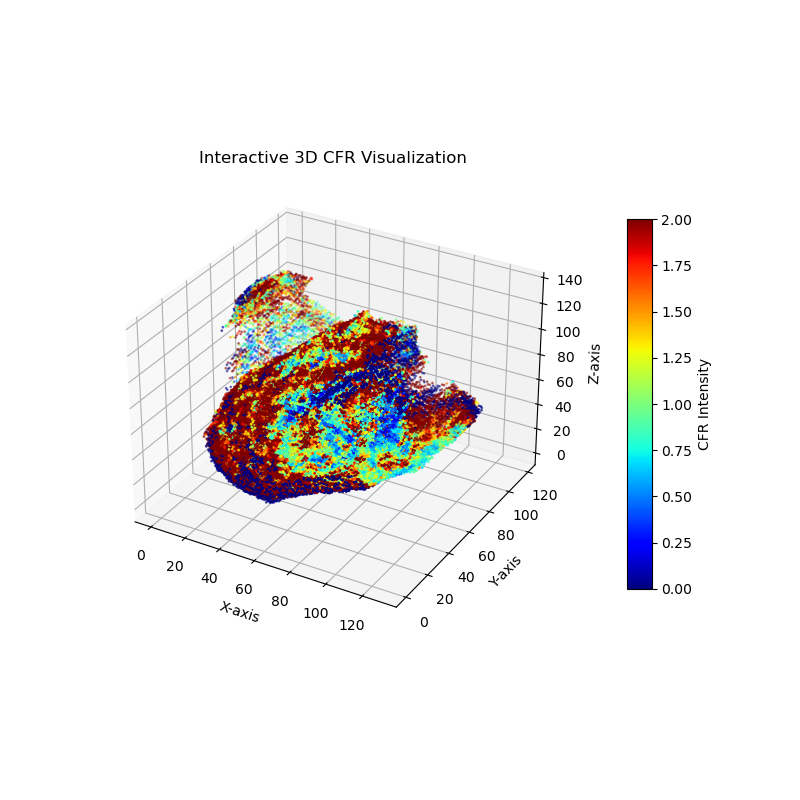

In [32]:
import matplotlib
matplotlib.use('module://ipympl.backend_nbagg')
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
box = find_bounding_box(dcm_mask_rest[:])
CFR_crop = crop_array(CFR_map, box)
mask_crop = crop_array(dcm_mask_rest[:], box)
x, y, z = np.indices(mask_crop.shape)

# Filter the coordinates and CFR values using the mask
mask_indices = mask_crop[:].nonzero()
x_masked = x[mask_indices]
y_masked = y[mask_indices]
z_masked = z[mask_indices]
CFR_masked = CFR_crop[mask_indices]

sample_rate = 5  # Adjust the sampling rate for fewer points
x_masked = x_masked[::sample_rate]
y_masked = y_masked[::sample_rate]
z_masked = z_masked[::sample_rate]
CFR_masked = CFR_masked[::sample_rate]

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Interactive 3D CFR Visualization")
# Plot only the masked values
scatter = ax.scatter(
    x_masked,
    y_masked,
    z_masked,
    c=CFR_masked,
    cmap="jet",
    vmin=0,
    vmax=2,
    s=1
)

# Add a colorbar and adjust its position
colorbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=15, pad=0.1)
colorbar.set_label("CFR Intensity")
plt.show()

